In [1]:
import nltk
import random
from nltk.corpus import wordnet, stopwords
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Define EDA Functions

In [2]:
def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)
    return sentence

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' abcdefghijklmnopqrstuvwxyz'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return ' '.join(new_words)

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = random.choice(list(synonyms))
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

def random_swap(words, n):
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    return ' '.join(new_words)

def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
    return new_words

def random_deletion(words, p):
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]
    return ' '.join(new_words)

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
    sentence = sentence.lower()
    words = sentence.split(' ')
    words = [word for word in words if word != '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug/4)+1
    n_sr = max(1, int(alpha_sr*num_words))
    n_ri = max(1, int(alpha_ri*num_words))
    n_rs = max(1, int(alpha_rs*num_words))

    augmented_sentences.extend([synonym_replacement(words, n_sr) for _ in range(num_new_per_technique)])
    augmented_sentences.extend([random_insertion(words, n_ri) for _ in range(num_new_per_technique)])
    augmented_sentences.extend([random_swap(words, n_rs) for _ in range(num_new_per_technique)])
    augmented_sentences.extend([random_deletion(words, p_rd) for _ in range(num_new_per_technique)])

    augmented_sentences = [sentence for sentence in augmented_sentences if sentence != '']
    random.shuffle(augmented_sentences)

    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        augmented_sentences = []

    augmented_sentences.append(sentence)

    return augmented_sentences


# Load and Preprocess the IMDB Dataset

In [3]:
# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

# Pad sequences to ensure uniform input size
max_len = 200
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# Word index dictionary
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# Convert sequences back to text
def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

decoded_reviews = [decode_review(sequence) for sequence in x_train]


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Apply EDA to Augment the Data

In [4]:
# Apply EDA and collect augmented reviews and their corresponding labels
augmented_reviews = []
augmented_labels = []

for review, label in tqdm(zip(decoded_reviews, y_train), total=len(y_train)):
    augmented = eda(review, num_aug=4)  # Generate 4 augmented reviews per original review
    augmented_reviews.extend(augmented)
    augmented_labels.extend([label] * len(augmented))  # Repeat the label for each augmented review

# Re-encode Augmented Reviews
def encode_review(review):
    return [min(word_index.get(word, 2) + 3, 20000 - 1) for word in review.split()]

encoded_augmented_reviews = [encode_review(review) for review in augmented_reviews]

# Pad the Augmented Reviews
padded_augmented_reviews = pad_sequences(encoded_augmented_reviews, maxlen=max_len)

# Combine with Original Dataset
x_train_augmented = np.concatenate((x_train, padded_augmented_reviews), axis=0)
y_train_augmented = np.concatenate((y_train, np.array(augmented_labels)), axis=0)

100%|██████████| 25000/25000 [03:25<00:00, 121.39it/s]


# Define and Train the Model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Define the model with stronger regularization and reduced complexity
model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=max_len),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.6),  # Increased dropout
    Dense(units=10, activation='relu', kernel_regularizer=regularizers.l2(0.05)),  # Stronger L2 regularization
    Dropout(0.6),  # Increased dropout
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(x_train_augmented, y_train_augmented, epochs=10, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 336s 71ms/step - accuracy: 0.7061 - loss: 0.6235 - val_accuracy: 0.8460 - val_loss: 0.3776
Epoch 2/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 334s 71ms/step - accuracy: 0.9068 - loss: 0.2600 - val_accuracy: 0.8338 - val_loss: 0.4952
Epoch 3/10
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 391s 73ms/step - accuracy: 0.9313 - loss: 0.1897 - val_accuracy: 0.8333 - val_loss: 0.6804


In [6]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8483 - loss: 0.3750
Test Accuracy: 0.8460


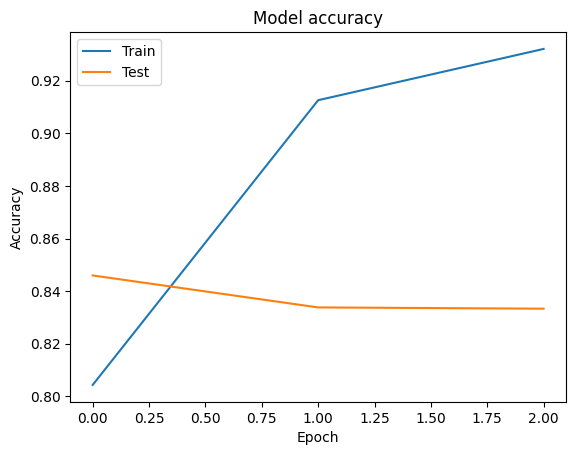

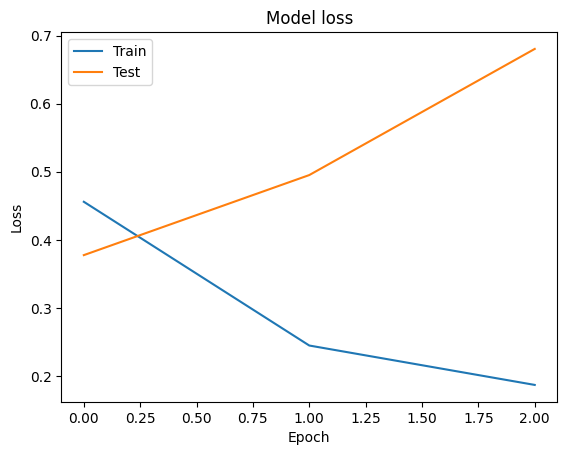

In [7]:
# Plot Accuracy Curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot Loss Curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()